# Small Task Packing

This notebook demonstrates the workload behaviour for small task packing

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import json
import os
import subprocess

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
androidsdk_path=os.path.join(os.getcwd(), "../../../android-sdk")
my_target_conf = {
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : androidsdk_path,
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
#             'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Define devlib module to load
    #"modules"     : [
    #    'bl',           # enable big.LITTLE support
    #    'cpufreq'       # enable CPUFreq support
    #],




}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    'modules' : [ "cpufreq", "cgroups" ],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
                 
            "cpu_capacity",
            
            #/sys/kernel/debug/tracing/events/sched
            "sched_blocked_reason",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_contrib_scale_f",
            "sched_cpu_hotplug",
            "sched_energy_diff",
            "sched_kthread_stop",
            "sched_kthread_stop_ret",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_migrate_task",
            "sched_move_numa",
            "sched_pi_setprio",
            "sched_process_exec",
            "sched_process_exit",
            "sched_process_fork",
            "sched_process_free",
            "sched_process_wait",
            "sched_stat_blocked",
            "sched_stat_iowait",
            "sched_stat_runtime",
            "sched_stat_sleep",
            "sched_stat_wait",
            "sched_stick_numa",
            "sched_swap_numa",
            "sched_switch",
            "sched_tune_boostgroup_update",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_filter",
            "sched_wait_task",
            "sched_wake_idle_without_ipi",
            "sched_wakeup",
            "sched_wakeup_new",
             "sched*",
            
            
         ],
         "buffsize" : 10240
    },
    "results_dir" : "lisa_small_task_packing",
}

In [4]:
# Support to access the remote target
import devlib
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

05:22:30  INFO    : Using base path: /home/steven/lisa/lisa-github
05:22:30  INFO    : Loading custom (inline) target configuration
05:22:30  INFO    : Loading custom (inline) test configuration
05:22:30  WARNING : Wipe previous contents of the results folder:
05:22:30  WARNING :    /home/steven/lisa/lisa-github/results/lisa_small_task_packing
05:22:30  INFO    : External tools using:
05:22:30  INFO    :    ANDROID_HOME: /home/steven/lisa/lisa-github/ipynb/workshop/../../../android-sdk
05:22:30  INFO    :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
05:22:30  INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq', 'cgroups']
05:22:30  INFO    : Connecting Android target [0123456789ABCDEF]
05:22:30  INFO    : Connection settings:
05:22:30  INFO    :    {'device': '0123456789ABCDEF'}
05:22:31  INFO    : Initializing target workdir:
05:22:31  INFO    :    /data/local/tmp/devlib-target
05:22:31  INFO    : Available controllers:
05:22:31  INFO    :   cpuset       : 

# Workload configuration 1

In [5]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp1 = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp1.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',    
    
    # 2. define the "profile" of each task
    params={
        'stp_0': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=10,     # duty cycle
            duration_s=10,          # duration
            cpus=str(target.bl.bigs[0]),
        ).get(),
        'stp_1': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=10,     # duty cycle
            duration_s=10,          # duration
            cpus=str(target.bl.bigs[1]),
        ).get(),
        'stp_2': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=10,     # duty cycle
            duration_s=10,          # duration
            cpus=str(target.bl.bigs[2]),
        ).get(),
        'stp_3': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=10,     # duty cycle
            duration_s=10,          # duration
            cpus=str(target.bl.bigs[3]),
        ).get(),

    },    
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);
        
rtapp2 = RTA(target, 'simple2', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp2.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',    
    
    # 2. define the "profile" of each task
    params={
        'stp_4': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            delay_s=1,
        ).get(),
        'stp_5': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            delay_s=1.1,
        ).get(),
        'stp_6': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            delay_s=1.3,
        ).get(),
        'stp_7': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=1,     # duty cycle
            duration_s=10,          # duration
            delay_s=1.5,
        ).get(),

    },    
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);        

05:22:36  INFO    : Setup new workload simple
05:22:36  INFO    : Workload duration defined by longest task
05:22:36  INFO    : Default policy: SCHED_OTHER
05:22:36  INFO    : ------------------------
05:22:36  INFO    : task [stp_0], sched: using default policy
05:22:36  INFO    :  | loops count: 1
05:22:36  INFO    :  | CPUs affinity: 4
05:22:36  INFO    : + phase_000001: duration 10.000000 [s] (100 loops)
05:22:36  INFO    : |  period   100000 [us], duty_cycle  10 %
05:22:36  INFO    : |  run_time  10000 [us], sleep_time  90000 [us]
05:22:36  INFO    : ------------------------
05:22:36  INFO    : task [stp_1], sched: using default policy
05:22:36  INFO    :  | loops count: 1
05:22:36  INFO    :  | CPUs affinity: 5
05:22:36  INFO    : + phase_000001: duration 10.000000 [s] (100 loops)
05:22:36  INFO    : |  period   100000 [us], duty_cycle  10 %
05:22:36  INFO    : |  run_time  10000 [us], sleep_time  90000 [us]
05:22:36  INFO    : ------------------------
05:22:36  INFO    : task [s

# Workload execution

In [6]:
# Set Sched governor
#
# For Juno big/LITTLE CPUs
#
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

target.cpufreq.set_all_governors('schedutil')

logging.info("Target current governor: %s",
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_governor")
            )
logging.info("Target big CPU max CPUfreq:%s\n\t\t    Target big CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu4/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu4/cpufreq/scaling_cur_freq")
             )

logging.info("Target LITTLE CPU max CPUfreq:%s \n\t\t    Target LITTLE CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq")
             )

05:22:36  INFO    : Target ABI: arm64, CPus: ['A53', 'A53', 'A53', 'A53', 'A73', 'A73', 'A73', 'A73']
05:22:37  INFO    : Target current governor: schedutil
05:22:37  INFO    : Target big CPU max CPUfreq:2362000
		    Target big CPU current CPUfreq: 903000
05:22:37  INFO    : Target LITTLE CPU max CPUfreq:1844000 
		    Target LITTLE CPU current CPUfreq: 1844000


In [7]:
schedtune = target.cgroups.controller('schedtune')

# Configure a 50% boostgroup
boostgroup = schedtune.cgroup('/boosted')
boostgroup.set(boost=50)

# Dump the configuraiton of each groups
cgroups = schedtune.list_all()
for cgname in cgroups:
    cgroup = schedtune.cgroup(cgname)
    attrs = cgroup.get()
    boost = attrs['boost']
    print '{}:{:<15} boost: {}'.format(schedtune.kind, cgroup.name, boost)

schedtune:/               boost: 0
schedtune:/foreground     boost: 0
schedtune:/boosted        boost: 50
schedtune:/background     boost: 0
schedtune:/top-app        boost: 10


In [8]:
import time
from devlib.utils.android import *

te.target.adb_root(True)
te.target.execute("stop")

''

In [9]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

time.sleep(5)
logging.info('#### Start RTApp execution')
rtapp1.run(out_dir=te.res_dir, cgroup="", background=True)
rtapp2.run(out_dir=te.res_dir, cgroup=boostgroup.name)

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

05:22:41  INFO    : #### Setup FTrace
05:22:45  INFO    : #### Start energy sampling
05:22:51  INFO    : #### Start RTApp execution
05:22:51  INFO    : Workload execution START:
05:22:51  INFO    :    CGMOUNT=/data/local/tmp/devlib-target/cgroups /data/local/tmp/bin/shutils cgroups_run_into /boosted /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple2_00.json 2>&1
05:23:03  INFO    : #### Read energy consumption: /home/steven/lisa/lisa-github/results/lisa_small_task_packing/energy.json
05:23:03  ERROR   : /usr/bin/iio-capture terminated for Device1 (iio:device1)
05:23:03  ERROR   : [ERROR: Unable to find host: Name or service not known
Unable to create IIO context
]
05:23:04  ERROR   : /usr/bin/iio-capture terminated for Device0 (iio:device0)
05:23:04  ERROR   : [ERROR: Unable to find host: Name or service not known
Unable to create IIO context
]
05:23:04  INFO    : #### Stop FTrace
05:23:04  INFO    : #### Save FTrace: /home/steven/lisa/lisa-github/results/lisa_small_task_

# Collected results

In [10]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
#!ls -la {te.res_dir}

05:23:06  INFO    : Content of the output folder /home/steven/lisa/lisa-github/results/lisa_small_task_packing


In [11]:
# Inspect the JSON file used to run the application
with open('{}/simple2_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
#print json.dumps(rtapp_json, indent=4, sort_keys=True)

05:23:07  INFO    : Generated RTApp JSON file:


In [12]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

05:23:07  INFO    : Energy: /home/steven/lisa/lisa-github/results/lisa_small_task_packing/energy.json


{}


In [13]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
#print json.dumps(plt, indent=4, sort_keys=True)

05:06:31  INFO    : Platform description: /home/steven/lisa/lisa-github/results/lisa_small_task_packing/platform.json


# Trace inspection

In [17]:
# Suport for FTrace events parsing and visualization
import trappy


trappy.register_dynamic_ftrace("eastestc", "casec")
trappy.register_dynamic_ftrace("eastestb1", "caseb1")
trappy.register_dynamic_ftrace("eastestb2", "caseb2")
trappy.register_dynamic_ftrace("eastest1", "case1")




# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.eastestb2 object at 0x7f5747276c90> from cache, reading it from trace
  warnings.warn(warnstr)
/home/steven/lisa/lisa-github/libs/trappy/trappy/ftrace.py:274: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.eastestb1 object at 0x7f5747276e10> from cache, reading it from trace
  warnings.warn(warnstr)


# New Task Behavior

In [32]:
events_to_parse = my_tests_conf['ftrace']['events']

trace = Trace(plt, te.res_dir, events_to_parse)

ftrace = trace.ftrace

trappy.plotter.plot_trace(ftrace, execnames=[
#     'stp_0',   "stp_1", "stp_2",
#                                              "stp_3", "stp_4", "stp_5",
     "stp_6"
                                            ])

06:02:35  INFO    : Platform clusters verified to be Frequency coherent


In [19]:
df=ftrace.eastestc.data_frame

In [25]:
dfb=ftrace.eastestb1.data_frame
select=(dfb.task=='stp_6')
dfb[select]

,__comm,__cpu,__line,__pid,deep_idle_cpu,pid,task
Time,,,,,,,
6.505283,stp_4,7,31188,6592,6,6594,stp_6
7.807258,<idle>,7,40724,0,5,6594,stp_6
7.807260,<idle>,7,40725,0,6,6594,stp_6
7.905612,<idle>,7,41410,0,5,6594,stp_6
7.905613,<idle>,7,41411,0,6,6594,stp_6
8.007247,<idle>,7,42221,0,5,6594,stp_6
8.007248,<idle>,7,42222,0,6,6594,stp_6
8.105891,<idle>,7,43160,0,6,6594,stp_6
8.307559,<idle>,7,44890,0,6,6594,stp_6


In [26]:
dfb2=ftrace.eastestb2.data_frame
select=(dfb2.task=='stp_6')
dfb2[select]

,__comm,__cpu,__line,__pid,idle_cpu,idle_min_cap,pid,task
Time,,,,,,,,
6.505281,stp_4,7,31186,6592,4,1024,6594,stp_6
6.505282,stp_4,7,31187,6592,5,1024,6594,stp_6
7.807256,<idle>,7,40723,0,4,1024,6594,stp_6
7.807261,<idle>,7,40726,0,7,1024,6594,stp_6
7.905611,<idle>,7,41409,0,4,1024,6594,stp_6
7.905614,<idle>,7,41412,0,7,1024,6594,stp_6
8.007245,<idle>,7,42220,0,4,1024,6594,stp_6
8.105890,<idle>,7,43156,0,4,1024,6594,stp_6
8.207593,<idle>,7,44245,0,7,1024,6594,stp_6


In [27]:

select=(df.task == 'stp_6')
df[select]

,__comm,__cpu,__line,__pid,capacity_orig,new_util,pid,target_cpu,target_max_spare_cap,task
Time,,,,,,,,,,
6.505283,stp_4,7,31189,6592,1024,588,6594,7,436,stp_6
8.007250,<idle>,7,42223,0,1024,544,6594,7,480,stp_6
8.105891,<idle>,7,43158,0,1024,578,6594,5,446,stp_6
8.105893,<idle>,7,43162,0,1024,578,6594,7,446,stp_6
8.207586,<idle>,7,44242,0,1024,536,6594,4,488,stp_6
8.207589,<idle>,7,44243,0,1024,536,6594,5,488,stp_6
8.207591,<idle>,7,44244,0,1024,536,6594,6,488,stp_6
8.307555,<idle>,7,44887,0,1024,812,6594,4,212,stp_6
8.407467,<idle>,4,45618,0,1024,598,6594,4,426,stp_6


05:58:58  INFO    : Plotting [6593:stp_5]...
05:58:59  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:58:59  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:58:59  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:59:00  INFO    : Plotting [6594:stp_6]...
05:59:00  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:59:00  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:59:00  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:59:01  INFO    : Plotting [6595:stp_7]...
05:59:01  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:59:01  WARNING : Event [sched_overutilized] not found, plot DISABLED!
05:59:01  WARNING : Event [sched_overutilized] not found, plot DISABLED!


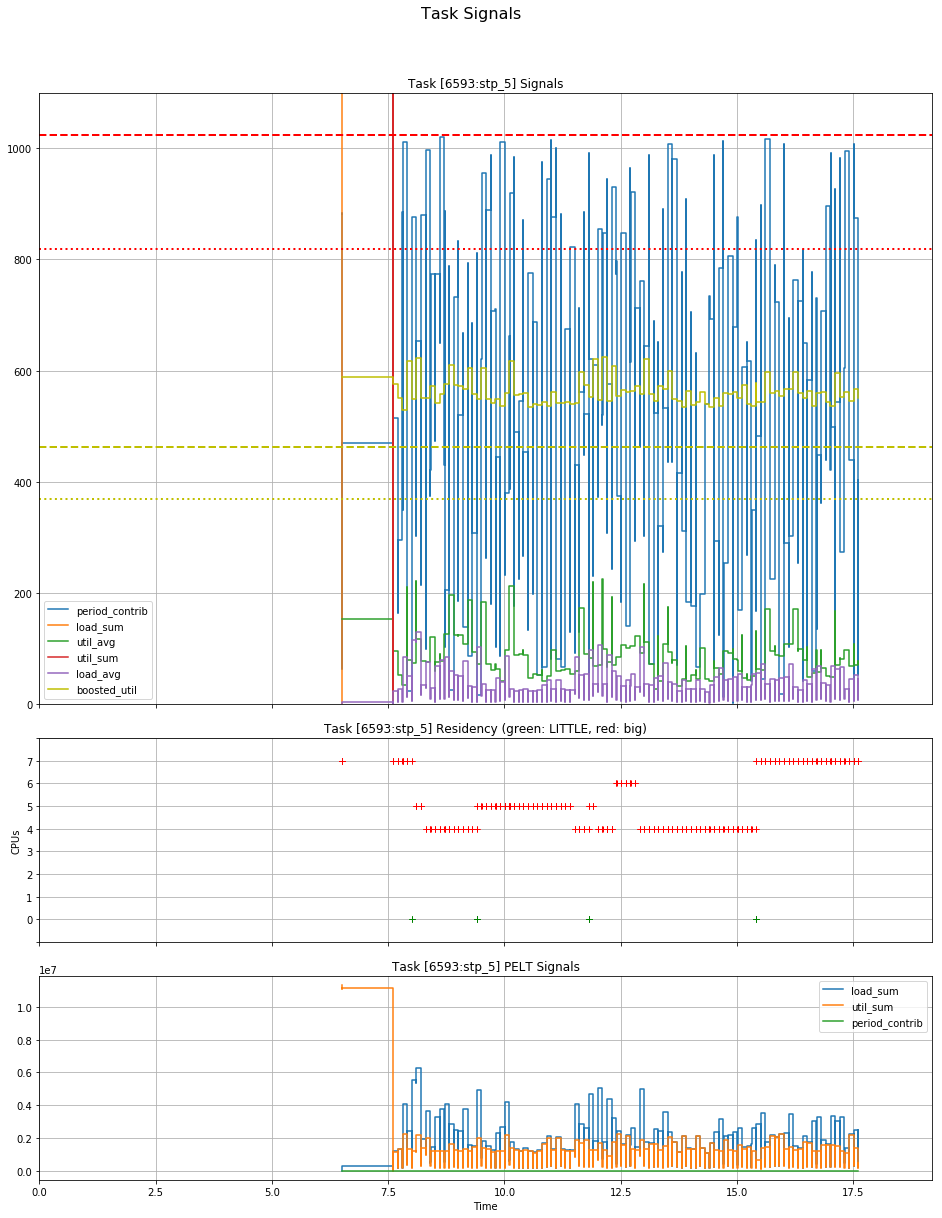

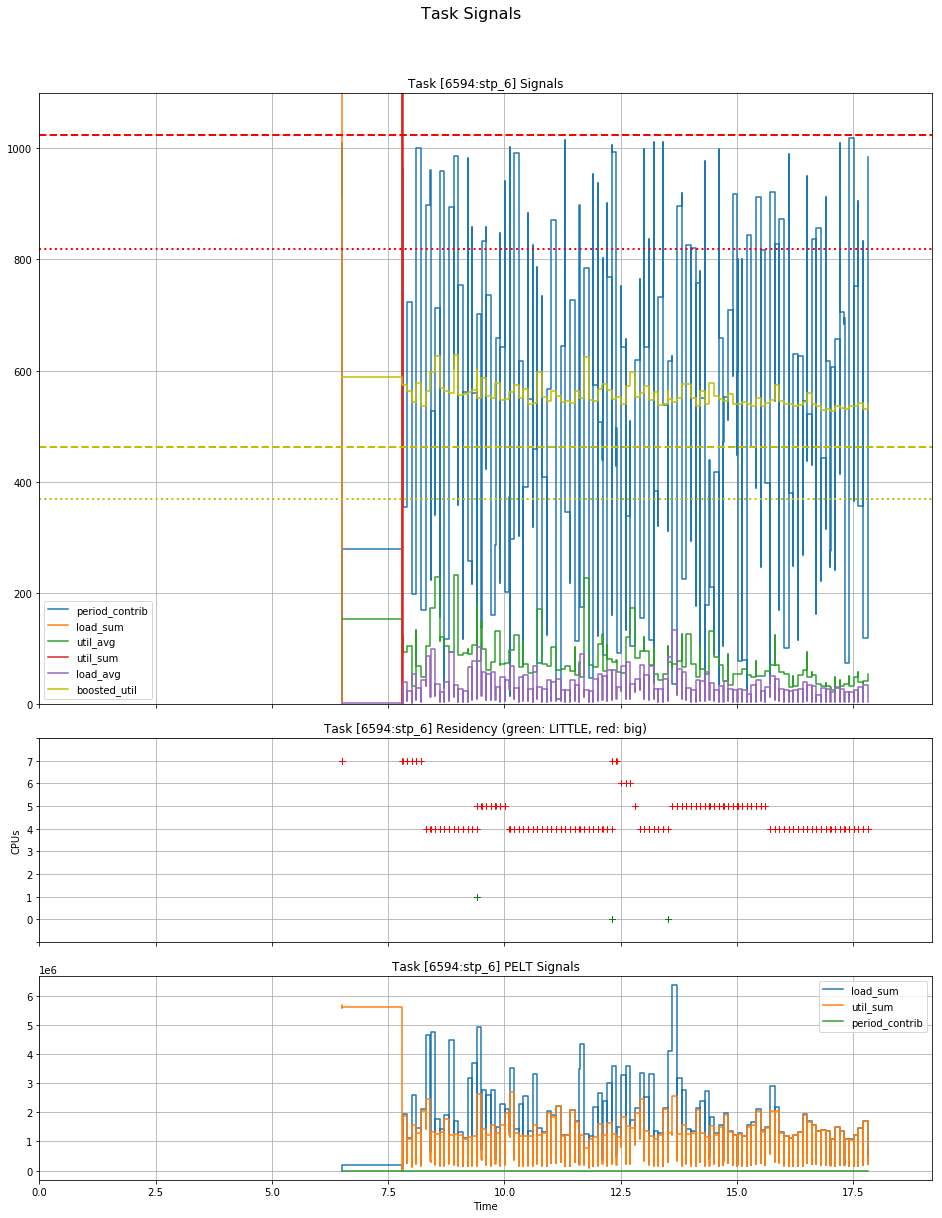

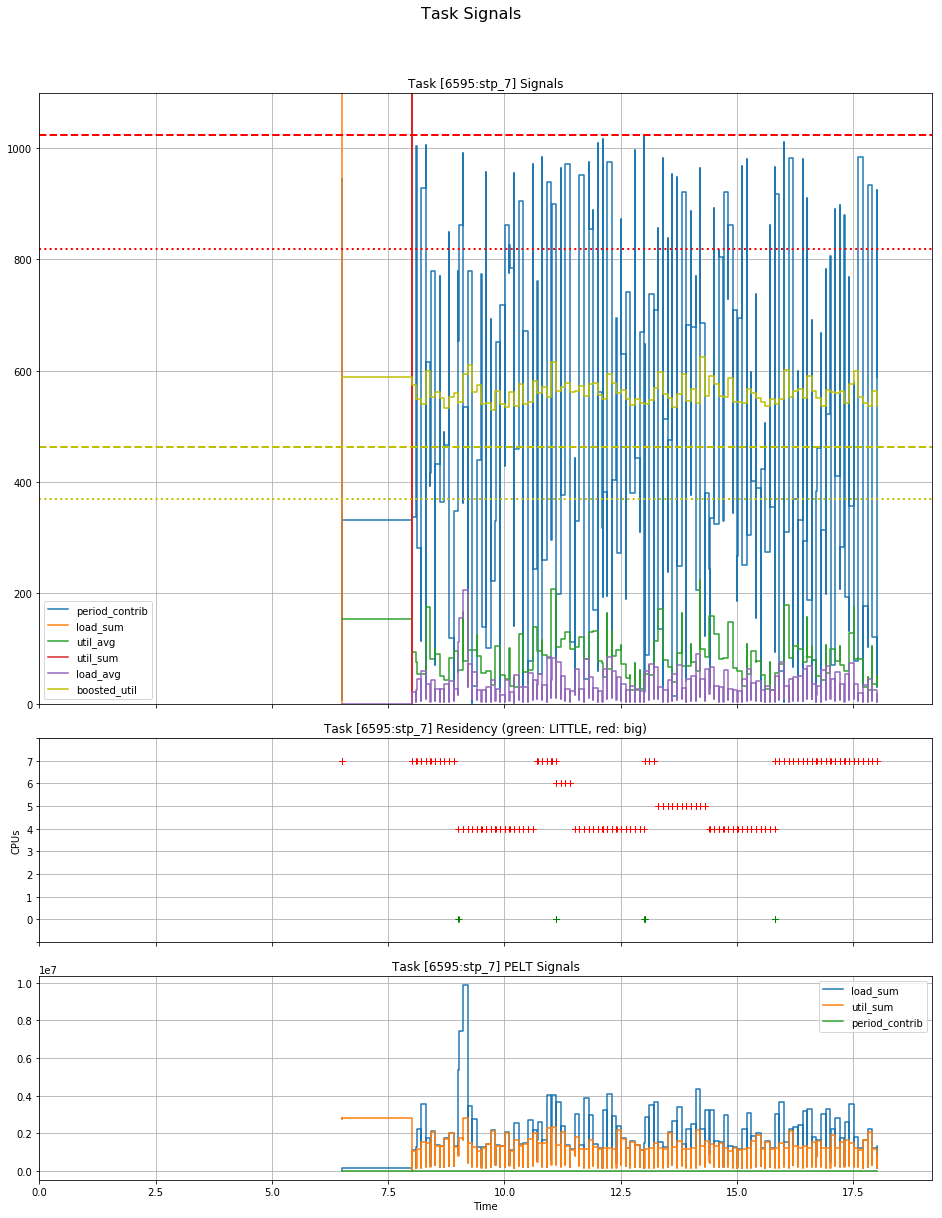

In [28]:
trace.analysis.tasks.plotTasks(tasks=['stp_5', 'stp_6', 'stp_7'])

04:41:29  WARNING : Event [sched_overutilized] not found, plot DISABLED!
04:41:29  WARNING : Event [sched_overutilized] not found, plot DISABLED!
04:41:29  WARNING : Event [sched_overutilized] not found, plot DISABLED!
04:41:29  WARNING : Event [sched_overutilized] not found, plot DISABLED!
04:41:30  WARNING : Event [sched_overutilized] not found, plot DISABLED!
04:41:30  WARNING : Event [sched_overutilized] not found, plot DISABLED!
04:41:31  WARNING : Event [sched_overutilized] not found, plot DISABLED!
04:41:31  WARNING : Event [sched_overutilized] not found, plot DISABLED!


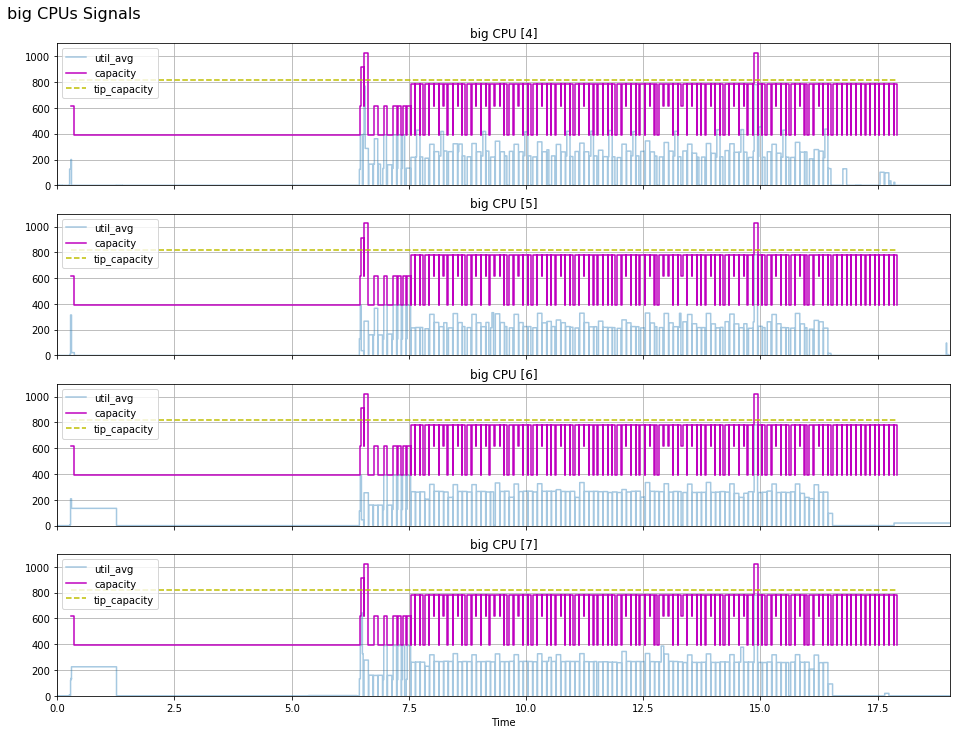

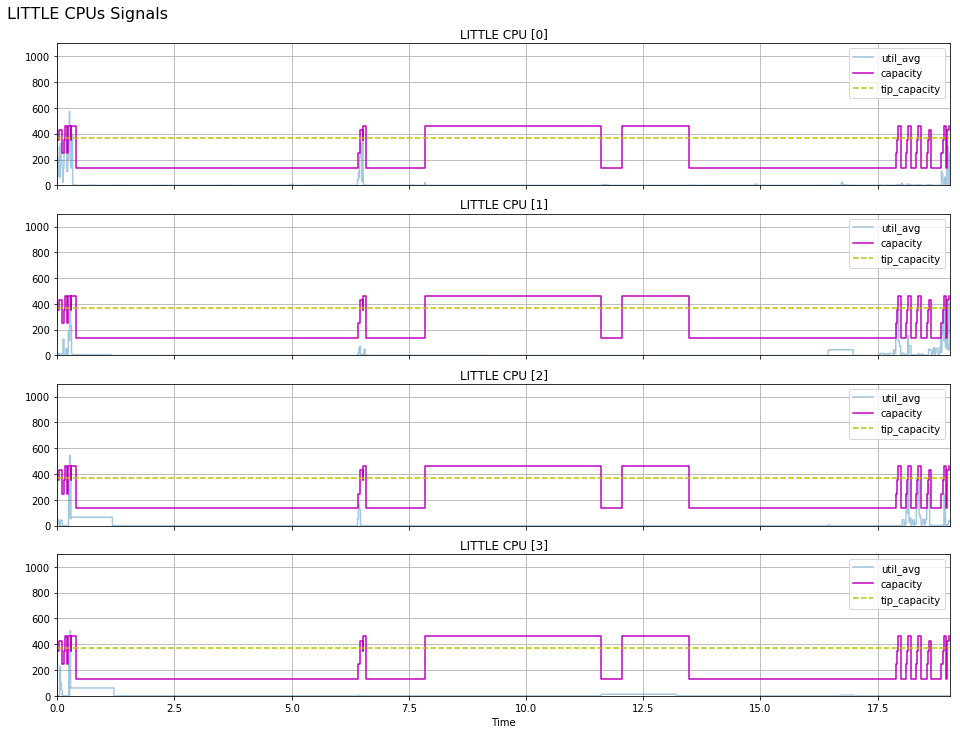

In [28]:
trace.analysis.cpus.plotCPU()